<a href="https://colab.research.google.com/github/nithinreganti/Neighnourhood-Ranking---Third-Estate-Analytics-Buffalo-NY---Capstone-Project-AWS-EC2-/blob/master/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

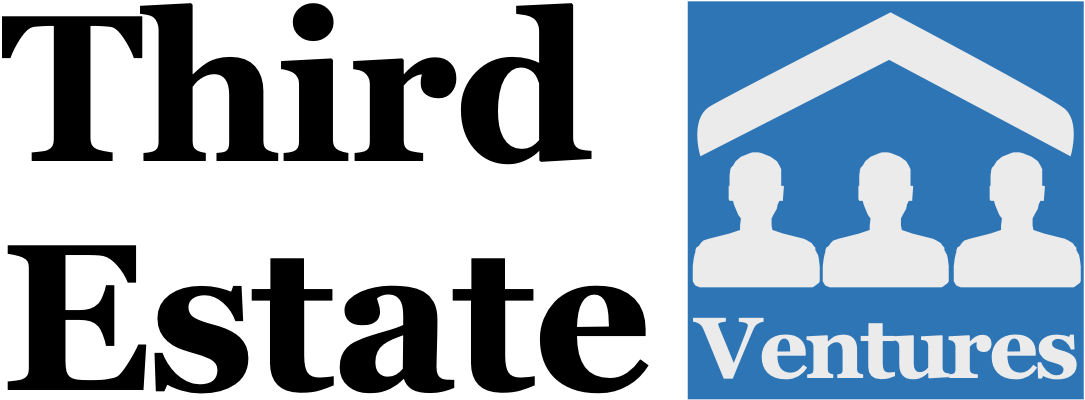

In [3]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/Gentrification/logo.jpg", width=1000, height=300)

## Overview about the company 

##### Third estate analytics is a company owned by Third Estate Ventures which is a real estate agency in the Buffalo/Niagara region. The organisation is developing a tool which can be used to suggest neighborhoods based on the need and amount of development it had over years. They are interested in investing on the fastest developing regions in all the similar sized cities.  

## Problem statement 

The client is interested in investing in the regions which might develop in the forthcoming years. The overall idea of the project is to build a model which can determine the ranking of all the neighborhoods across the Buffalo in order of development over years .The broader scope of the project is to run the model across all the similar sized cities across the US . 

***Dataset*** : To achieve the above goal the datasets are being taken from Open data portal of Buffalo .
URL : https://data.buffalony.gov/
The datasets considered are :
1. Tows 
2. Parking Violations
3. Code Violations
4. Assessment Roll 
5. Housing Violations 

### Number of Records - 2.5 million rows

The datasets are mapped against walkscore and assessement value

***Walkscore***:Walk Score measures the walkability of any address using a patented system. Walk Score also measures pedestrian friendliness by analyzing population density and road metrics such as block length and intersection density

***Assessed Value***:An assessed value is the dollar value assigned to a property to measure applicable taxes. Assessed valuation determines the value of a residence for tax purposes and takes comparable home sales and inspections into consideration

**Libraries Used**: Pandas,numpy,seaborn,matplotlib,scipy,sklearn,tensorflow

**Machine Learning Models**

Linear regression(Ridge regression)

Datasets considered
1. Parking violations
2. Housing court violations
3. Business Licenses
4. Permits
5. 311 service requests

### Importing the required libaries for Exploratory data analysis and Machine learning

In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error

### Mounting the google drive to google colab notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Connecting and using GPU 

In [4]:
import tensorflow as tf 
tf.test.gpu_device_name()

''

### Storing all the file paths in a list

In [0]:
files = ['/content/drive/My Drive/Gentrification/Parking_Summonses .csv',
         '/content/drive/My Drive/Gentrification/Housing_Court_Cases.csv',
         '/content/drive/My Drive/Gentrification/Business_Licesnces_Updated_Description.xlsx',
         '/content/drive/My Drive/Gentrification/Permits.csv',
         '/content/drive/My Drive/Gentrification/311_Service_Requests.csv'
        ]

years = [2015, 2016, 2017, 2018]

### Function to fetch the parking violations dataframe
Data Cleaning performed
1. Only the columns Violation description , census tract and summons date are considered and rest are eliminated
2. Census tracts with unknown values are removed
3. The data is reduced for a particular year
4. The dummy value is created for all the text data in order to perform        regression.
5. Nulls are being dropped from the dataframe
6. Printing total number of census tracts each year and missing values.

### Function to fetch Parking Violations dataframe

In [0]:
def get_parking_df(year, parking):
    parking = parking[['VIOLATION DESCRIPTION', 'CENSUS TRACT', 'SUMMONS DATE']]
    parking = parking[parking['CENSUS TRACT'] != 'UNKNOWN']
    parking['CENSUS TRACT'] = parking['CENSUS TRACT'].astype(float)
    parking['SUMMONS DATE'] = pd.to_datetime(parking['SUMMONS DATE'])
    parking = parking[parking['SUMMONS DATE'].dt.year == year]
    parking = parking[['VIOLATION DESCRIPTION', 'CENSUS TRACT']]
    parking = pd.get_dummies(parking)
    parking.dropna(inplace=True)
    print('PARKING ' +str(year)+ ' CT: ', parking['CENSUS TRACT'].nunique())
    print('PARKING ' +str(year)+ ' Missing Values: ', parking.isnull().sum().sum())
    return parking


### Function to fetch Housing Court Violations dataframe

In [0]:
def get_court_df(year, court):
    court = court[['CENSUS TRACT', 'RESOLUTION', 'LASTACTION']]
    court = court[court['CENSUS TRACT'] != 'UNKNOWN']
    court['CENSUS TRACT'] = court['CENSUS TRACT'].astype(float)
    court['LASTACTION'] = court['LASTACTION'].apply(lambda x: x.split(' A')[0])
    court['LASTACTION'] = pd.to_datetime(court['LASTACTION'])
    court = court[court['LASTACTION'].dt.year == year]
    court = court[['CENSUS TRACT', 'RESOLUTION']]
    court = pd.get_dummies(court)
    court.dropna(inplace=True)
    print('COURT ' +str(year)+ ' CT: ', court['CENSUS TRACT'].nunique())
    print('COURT ' +str(year)+ ' Missing Values: ', court.isnull().sum().sum())
    return court

### Function to fetch Business Licenses dataframe

In [0]:
def get_license_df(year, license):
    license = license[['CENSUS TRACT', 'DESCRIPT', 'STATUSDTTM']]
    license = license[license['CENSUS TRACT'] != 'UNKNOWN']
    license['CENSUS TRACT'] = license['CENSUS TRACT'].astype(float)
    license['STATUSDTTM'] = pd.to_datetime(license['STATUSDTTM'])
    license = license[license['STATUSDTTM'].dt.year == year]
    license = license[['CENSUS TRACT', 'DESCRIPT']]
    license = pd.get_dummies(license)
    license.dropna(inplace=True)
    print('LICENSE ' +str(year)+ ' CT: ', license['CENSUS TRACT'].nunique())
    print('LICENSE ' +str(year)+ ' Missing Values: ', license.isnull().sum().sum())
    return license

### Function to fetch Permits dataframe

In [0]:
def get_permit_df(year, permit):
    permit = permit[['PERMIT TYPE', 'CENSUS TRACT', 'ISSUED']]
    permit = permit[permit['CENSUS TRACT'] != 'UNKNOWN']
    permit['ISSUED'] = pd.to_datetime(permit['ISSUED'])
    permit['CENSUS TRACT'] = permit['CENSUS TRACT'].astype(float)
    permit = permit[permit['ISSUED'].dt.year == year]
    permit = permit[['PERMIT TYPE', 'CENSUS TRACT']]
    permit = pd.get_dummies(permit)
    permit.dropna(inplace=True)
    permit = permit.sample(n=1000, random_state=14)
    print('PERMIT ' +str(year)+ ' CT: ', permit['CENSUS TRACT'].nunique())
    print('PERMIT ' +str(year)+ ' Missing Values: ', permit.isnull().sum().sum())
    return permit

### Function to fetch 311 service requests dataframe

In [0]:
def get_service_df(year, service):
    service = service[['TYPE', 'CENSUS TRACT', 'CLOSED DATE']]
    service = service[service['CENSUS TRACT'] != 'UNKNOWN']
    service['CENSUS TRACT'] = service['CENSUS TRACT'].astype(float)
    service['CLOSED DATE'] = pd.to_datetime(service['CLOSED DATE'])
    service = service[service['CLOSED DATE'].dt.year == year]
    service = service[['TYPE', 'CENSUS TRACT']]
    service = pd.get_dummies(service)
    service.dropna(inplace=True)
    service = service.sample(n=1000, random_state=27)
    print('SERVICE ' +str(year)+ ' CT: ', service['CENSUS TRACT'].nunique())
    print('SERVICE ' +str(year)+ ' Missing Values: ', service.isnull().sum().sum())
    return service
    

### Function to merge dataframes
When the merge function is called it fetches all the dataframes for a particular year and performs a left join to the parking violations dataset .
Left join is performed in order to handle the missing census tract values in the remaining datasets 

In [0]:
def merge_df(year, files):
    parking = pd.read_csv(files[0])
    print('Processing parking data for ' +str(year)+ '....')
    parking_df = get_parking_df(year, parking)
    del parking
    
    court = pd.read_csv(files[1])
    print('Processing court data for ' +str(year)+ '....')
    court_df = get_court_df(year, court)
    del court
    
    license = pd.read_excel(files[2])
    print('Processing license data for ' +str(year)+ '....')  
    license_df = get_license_df(year, license)
    del license
    
    permit = pd.read_csv(files[3])
    print('Processing permit data for ' +str(year)+ '....')
    permit_df = get_permit_df(year, permit)
    del permit
    
    service = pd.read_csv(files[4])
    print('Processing service data for ' +str(year)+ '....')
    service_df = get_service_df(year, service)
    del service
    
    df = pd.merge(parking_df, court_df, 'left', 'CENSUS TRACT')
    df = pd.merge(df, license_df, 'left', 'CENSUS TRACT')
    df = df.sample(n=100000)
    df = pd.merge(df, service_df, 'left', 'CENSUS TRACT')
    df = df.sample(n=100000)
    df = pd.merge(df, permit_df, 'left', 'CENSUS TRACT')
    
    print('Merged 5 datasets.')
    print('Shape: ', df.shape)
    print('Total CTs: ', df['CENSUS TRACT'].nunique())
    return df


Funstion to build Machine learning model(Ridge regression)

**Ridge Regression** is a technique for analyzing multiple regression data that suffer from multicollinearity. When multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value.

Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression .

In [0]:
def build_model(df):
    X = df.drop(columns = ['Rank', 'CENSUS TRACT'])
    y = df[['Rank', 'CENSUS TRACT']]
    del df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rank_df = y_test
    y_train = y_train['Rank']
    y_test = y_test['Rank']
    
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    
    predictions = ridge.predict(X_test)
    print('MAE: ', mean_absolute_error(y_test, predictions))
    
    cdf = pd.DataFrame({'Features': X_train.columns,
                        'Coefficients': ridge.coef_
                       }).sort_values(by='Coefficients', ascending=False)
    
    rank_df['PredictedRank'] = predictions
    
    return cdf, rank_df

Calculating Mean Absolute Error for each year by combining all the datasets and building the Ridge Regression Model.

##2018

In [0]:
year = 2018
df = merge_df(year, files)
rank = pd.read_csv('/content/drive/My Drive/Gentrification/census_rank_Assessmentprice_2018.csv')
rank = rank[rank['CENSUS TRACT'] != 'UNKNOWN']
rank['CENSUS TRACT'] = rank['CENSUS TRACT'].astype(float)
df = pd.merge(df, rank, 'left', 'CENSUS TRACT') 
df.fillna(value=0, inplace=True)
df.drop(columns=['Price/sqft'], inplace=True)
print('After applying rank to merged dataset.')
print('Shape: ', df.shape)
print('Total CTs: ', df['CENSUS TRACT'].nunique())
print('Total Missing Values: ', df.isnull().sum().sum())
cdf_2018, rank_2018 = build_model(df)
#         cdf_2018.to_csv('F:/Capstone/Results/cdf2018.csv', index=False)
#         rank_2018.to_csv('F:/Capstone/Results/rank2018.csv', index=False)
print('\n<------------------------------------------------->\n')
del df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing parking data for 2018....
PARKING 2018 CT:  79
PARKING 2018 Missing Values:  0
Processing court data for 2018....


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


COURT 2018 CT:  72
COURT 2018 Missing Values:  0
Processing license data for 2018....
LICENSE 2018 CT:  62
LICENSE 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (23,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing permit data for 2018....
PERMIT 2018 CT:  78
PERMIT 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,13,15,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing service data for 2018....
SERVICE 2018 CT:  79
SERVICE 2018 Missing Values:  0
Merged 5 datasets.
Shape:  (1978085, 238)
Total CTs:  77
After applying rank to merged dataset.
Shape:  (1978085, 239)
Total CTs:  77
Total Missing Values:  0
MAE:  8.999789089874136

<------------------------------------------------->



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##2017

In [0]:
year == 2017
df = merge_df(year, files)
rank = pd.read_csv('/content/drive/My Drive/Gentrification/census_rank_Assessmentprice_2017.csv')
rank = rank[rank['CENSUS TRACT'] != 'UNKNOWN']
rank['CENSUS TRACT'] = rank['CENSUS TRACT'].astype(float)
df = pd.merge(df, rank, 'left', 'CENSUS TRACT') 
df.fillna(value=0, inplace=True)
df.drop(columns=['Price/sqft'], inplace=True)
print('After applying rank to merged dataset.')
print('Shape: ', df.shape)
print('Total CTs: ', df['CENSUS TRACT'].nunique())
print('Total Missing Values: ', df.isnull().sum().sum())
cdf_2017, rank_2017 = build_model(df)
#         cdf_2017.to_csv('F:/Capstone/Results/cdf2017.csv', index=False)
#         rank_2017.to_csv('F:/Capstone/Results/rank2017.csv', index=False)
print('\n<------------------------------------------------->\n')
del df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing parking data for 2018....
PARKING 2018 CT:  79
PARKING 2018 Missing Values:  0
Processing court data for 2018....


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


COURT 2018 CT:  72
COURT 2018 Missing Values:  0
Processing license data for 2018....
LICENSE 2018 CT:  62
LICENSE 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (23,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing permit data for 2018....
PERMIT 2018 CT:  78
PERMIT 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,13,15,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing service data for 2018....
SERVICE 2018 CT:  79
SERVICE 2018 Missing Values:  0
Merged 5 datasets.
Shape:  (1973981, 238)
Total CTs:  77
After applying rank to merged dataset.
Shape:  (1973981, 239)
Total CTs:  77
Total Missing Values:  0
MAE:  8.587859685495332

<------------------------------------------------->



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##2016

In [0]:
year == 2016
df = merge_df(year, files)
rank = pd.read_csv('/content/drive/My Drive/Gentrification/census_rank_Assessmentprice_2016.csv')
rank = rank[rank['CENSUS TRACT'] != 'UNKNOWN']
rank['CENSUS TRACT'] = rank['CENSUS TRACT'].astype(float)
df = pd.merge(df, rank, 'left', 'CENSUS TRACT') 
df.fillna(value=0, inplace=True)
df.drop(columns=['Price/sqft'], inplace=True)
print('After applying rank to merged dataset.')
print('Shape: ', df.shape)
print('Total CTs: ', df['CENSUS TRACT'].nunique())
print('Total Missing Values: ', df.isnull().sum().sum())
cdf_2016, rank_2016 = build_model(df)
#         cdf_2016.to_csv('F:/Capstone/Results/cdf2016.csv', index=False)
#         rank_2016.to_csv('F:/Capstone/Results/rank2016.csv', index=False)
print('\n<------------------------------------------------->\n')
del df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing parking data for 2018....
PARKING 2018 CT:  79
PARKING 2018 Missing Values:  0
Processing court data for 2018....


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


COURT 2018 CT:  72
COURT 2018 Missing Values:  0
Processing license data for 2018....
LICENSE 2018 CT:  62
LICENSE 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (23,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing permit data for 2018....
PERMIT 2018 CT:  78
PERMIT 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,13,15,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing service data for 2018....
SERVICE 2018 CT:  79
SERVICE 2018 Missing Values:  0
Merged 5 datasets.
Shape:  (1979072, 238)
Total CTs:  77
After applying rank to merged dataset.
Shape:  (1979072, 239)
Total CTs:  77
Total Missing Values:  0
MAE:  8.608251723340253

<------------------------------------------------->



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##2015

In [0]:
year == 2015
df = merge_df(year, files)
rank = pd.read_csv('/content/drive/My Drive/Gentrification/census_rank_Assessmentprice_2015.csv')
rank = rank[rank['CENSUS TRACT'] != 'UNKNOWN']
rank['CENSUS TRACT'] = rank['CENSUS TRACT'].astype(float)
df = pd.merge(df, rank, 'left', 'CENSUS TRACT') 
df.fillna(value=0, inplace=True)
df.drop(columns=['Price/sqft'], inplace=True)
print('After applying rank to merged dataset.')
print('Shape: ', df.shape)
print('Total CTs: ', df['CENSUS TRACT'].nunique())
print('Total Missing Values: ', df.isnull().sum().sum())
cdf_2015, rank_2015 = build_model(df)
#         cdf_2015.to_csv('F:/Capstone/Results/cdf2015.csv', index=False)
#         rank_2015.to_csv('F:/Capstone/Results/rank2015.csv', index=False)
print('\n<------------------------------------------------->\n')
del df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing parking data for 2018....
PARKING 2018 CT:  79
PARKING 2018 Missing Values:  0
Processing court data for 2018....


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


COURT 2018 CT:  72
COURT 2018 Missing Values:  0
Processing license data for 2018....
LICENSE 2018 CT:  62
LICENSE 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (23,25) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing permit data for 2018....
PERMIT 2018 CT:  78
PERMIT 2018 Missing Values:  0


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,13,15,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Processing service data for 2018....
SERVICE 2018 CT:  79
SERVICE 2018 Missing Values:  0
Merged 5 datasets.
Shape:  (1977971, 238)
Total CTs:  77
After applying rank to merged dataset.
Shape:  (1977971, 239)
Total CTs:  77
Total Missing Values:  0
MAE:  9.211493549467946

<------------------------------------------------->



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Highlighting the features which increased the rank in 2018

In [0]:
 cdf_2018.head()

,Features,Coefficients
44,DESCRIPT_Lodging House,37.586352
161,TYPE_Recycling Tote Abandon Pickup (Req_Serv),33.944710
135,TYPE_PVB Single Meter (Req_Serv),33.189995
57,DESCRIPT_Wholesale Junk,33.081078
175,TYPE_Signal Other Issue (Req_Serv),32.966060


### Highlighting the features which decreased the rank in 2018

In [0]:
 cdf_2018.tail()

,Features,Coefficients
232,PERMIT TYPE_SWIM POOL,-17.165109
85,TYPE_Damaged Street Light Pole (Req_Serv),-20.296996
81,TYPE_Curb - Metal Protruding (Req_Serv),-22.517122
109,TYPE_Graffiti Private Property (Req_Serv),-24.544237
61,TYPE_Assessment Issue (Req_Serv),-31.590799


In [0]:
 cdf_2018[cdf_2018['Features'].str.contains('DESCRIPT')].head()

,Features,Coefficients
44,DESCRIPT_Lodging House,37.586352
57,DESCRIPT_Wholesale Junk,33.081078
18,VIOLATION DESCRIPTION_NO VIOLATION,30.694348
54,DESCRIPT_Stationary Peddler,25.529779
55,DESCRIPT_Tire Handler,16.608212


In [0]:
 cdf_2018[cdf_2018['Features'].str.contains('DESCRIPT')].tail()

,Features,Coefficients
48,DESCRIPT_Restaurant,-11.262424
43,DESCRIPT_Live Music / No Dancing,-11.732416
41,DESCRIPT_Bowling Alley,-12.974906
47,DESCRIPT_Parking Lot,-15.542035
53,DESCRIPT_Sidewalk Cafe,-16.847349


### A sample of the actual and predicted Dataframe 

In [0]:
 rank_2018.sample(20)

,Rank,CENSUS TRACT,PredictedRank
303077,1,165.00,1.178758
1501865,1,165.00,2.005209
1228033,18,49.00,27.556526
247824,1,165.00,3.503998
1001521,61,31.00,41.456869
890371,18,49.00,22.912417
388020,15,52.01,24.914056
1076583,7,68.00,20.212401
1151925,1,165.00,8.586965
1731867,37,47.00,37.995014


### Showcasing the shift of neighborhoods over years using Tableau

In [8]:
%%HTML
<div class='tableauPlaceholder' id='viz1591071666229' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneNeighborhoodStabilization&#47;Ranks&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='CapstoneNeighborhoodStabilization&#47;Ranks' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ca&#47;CapstoneNeighborhoodStabilization&#47;Ranks&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1591071666229');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1000px';vizElement.style.height='827px';} else { vizElement.style.width='100%';vizElement.style.height='1077px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>